# Dimensionality Reduction, Feature Extraction, and Manifold Learning

Transforming data using unsupervised learning can have many motivations. The most common motivations are visualization, compressing and finding a more informative representation of the data.

Here, we'll explore (1) Principal Component Analysis; (2) Non-nagative Matrix Factorization (NMF) and (3) t-SNE.

## Principal Component Analysis

PCA rotates the data in a way that the rotated features are statistically uncorrelated. It also selects the most representative features according to their power to explain the data.

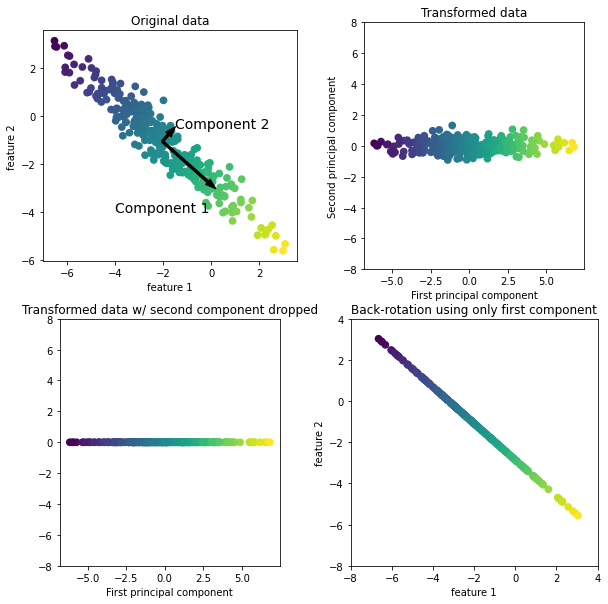

In [2]:
import mglearn
mglearn.plots.plot_pca_illustration()

The figure above, shows how PCA allows us to represent the original data in fewer dimensions. Notice that, Component 1 has higher variance than Component 2. So that, its better to use component 1 to explain the data.

# Applying PCA to the cancer dataset

We cannot plot datasets with more than 3 dimensions, thats why we used pairplot for visualize Iris Dataset.
However, it's hard to visualize Cancer Dataset using pairplot as it has 30 features. In this case, we would
have C(30, 2) = 30!/2!(30-2)! = 30*29/2 = 435 plots.

Therefore, let's compute histograms for each feature considering the two classes.

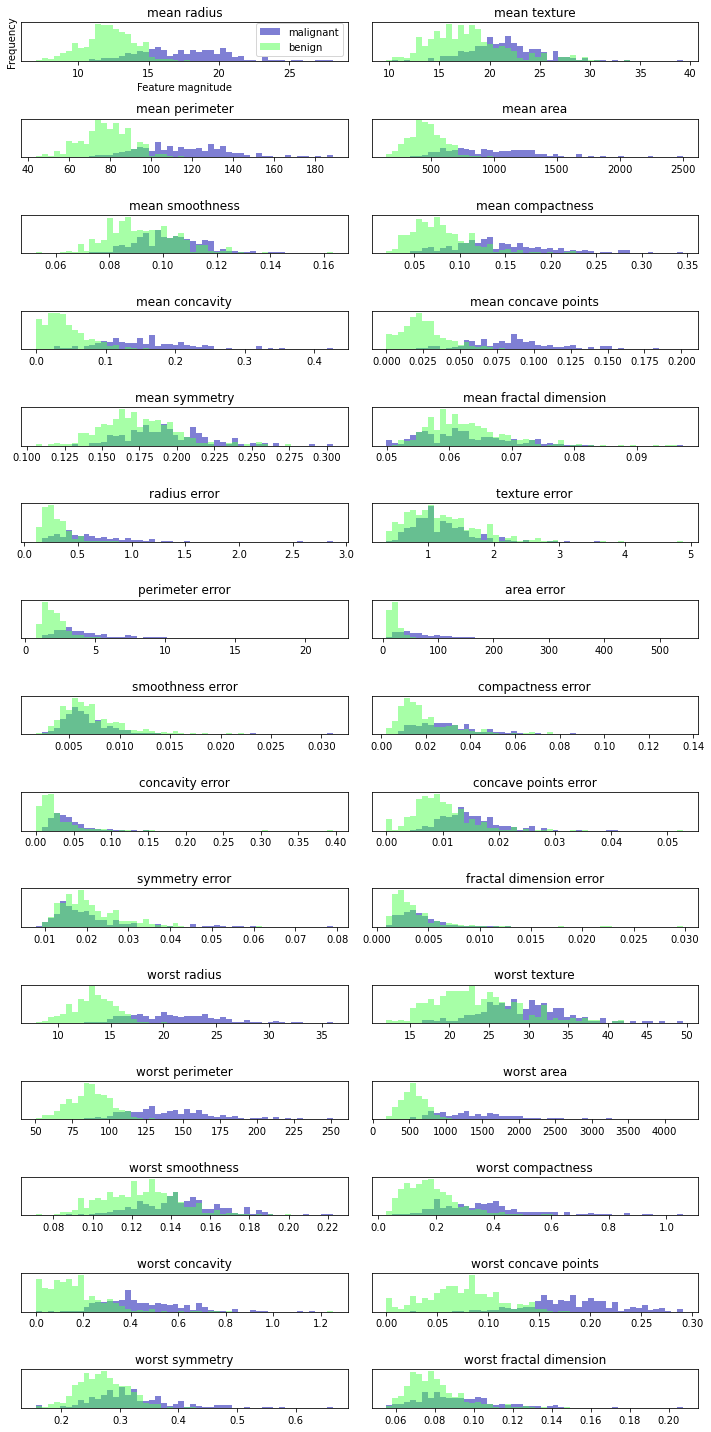

In [3]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()

fig, axes = plt.subplots(15, 2, figsize=(10, 20))

malignant = cancer.data[cancer.target == 0]
benign = cancer.data[cancer.target == 1]

ax = axes.ravel()

for i in range(30):
    _, bins = np.histogram(cancer.data[:, i], bins=50)
    ax[i].hist(malignant[:, i], bins=bins, color=mglearn.cm3(0), alpha=.5)
    ax[i].hist(benign[:, i], bins=bins, color=mglearn.cm3(2), alpha=.5)
    ax[i].set_title(cancer.feature_names[i])
    ax[i].set_yticks(())
    
ax[0].set_xlabel("Feature magnitude")
ax[0].set_ylabel("Frequency")
ax[0].legend(["malignant", "benign"], loc="best")

fig.tight_layout()

The histograms can be usefull in telling us which feature seems informative for classification. For example, "worst concave points" seems to be useful for distinguish the two classes while "symmetry error" alone seems uninformative.

Histograms tells us the story of the features alone, but it tells us nothing about the features interactions. Using PCA we can capture these interactions.

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler

#Load the data
cancer = load_breast_cancer()

#Scale the data
scaler = StandardScaler()
scaler.fit(cancer.data)

X_scaled = scaler.transform(cancer.data)

In [6]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)
print("Original shape: {}".format(str(X_scaled.shape)))
print("Reduced shape: {}".format(str(X_pca.shape)))

Original shape: (569, 30)
Reduced shape: (569, 2)


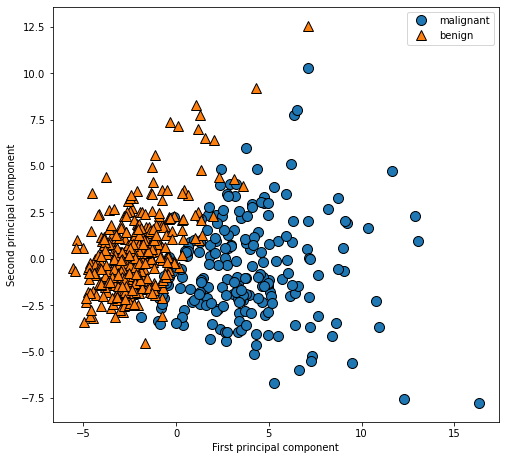

In [9]:
plt.figure(figsize=(8, 8))
mglearn.discrete_scatter(X_pca[:, 0], X_pca[:, 1], cancer.target)
plt.legend(cancer.target_names, loc="best")
plt.gca().set_aspect("equal")
plt.xlabel("First principal component")
plt.ylabel("Second principal component");

Text(0, 0.5, 'Principal components')

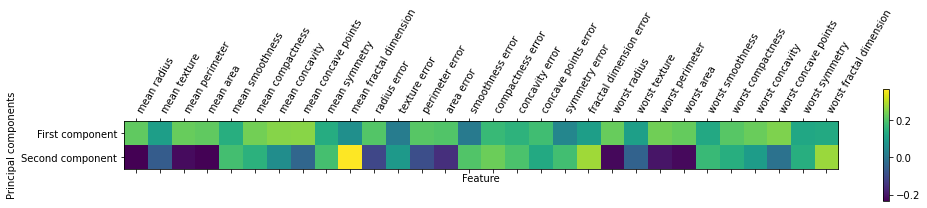

In [19]:
plt.matshow(pca.components_, cmap='viridis')
plt.yticks([0, 1], ["First component", "Second component"])
plt.colorbar()
plt.xticks(range(len(cancer.feature_names)), cancer.feature_names, rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components")

# Eigenfaces for feature extraction

An application of PCA is feature extraction. The hyphotesis here is that there is a better representation of our data and PCA can tells us what it is.

In the following example, I used face images of celebrities downloaded from the Internet and have the objective to find better matrix representations for them.

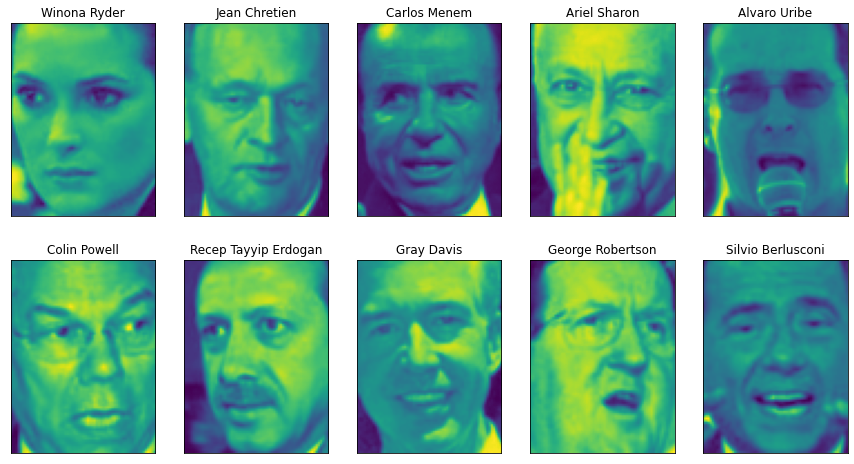

In [21]:
from sklearn.datasets import fetch_lfw_people
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)
image_shape = people.images[0].shape

fix, axes = plt.subplots(2, 5, figsize=(15,8), subplot_kw={'xticks': (), 'yticks': ()})

for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image)
    ax.set_title(people.target_names[target])

In [22]:
print("people.images.shape: {}".format(people.images.shape))
print("Number of classses: {}".format(len(people.target_names)))

people.images.shape: (3023, 87, 65)
Number of classses: 62


In [24]:
counts = np.bincount(people.target)

for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:25} {1:3}".format(name, count), end=' ')
    if (i + 1) % 3 == 0:
        print()

Alejandro Toledo           39 Alvaro Uribe               35 Amelie Mauresmo            21 
Andre Agassi               36 Angelina Jolie             20 Ariel Sharon               77 
Arnold Schwarzenegger      42 Atal Bihari Vajpayee       24 Bill Clinton               29 
Carlos Menem               21 Colin Powell              236 David Beckham              31 
Donald Rumsfeld           121 George Robertson           22 George W Bush             530 
Gerhard Schroeder         109 Gloria Macapagal Arroyo    44 Gray Davis                 26 
Guillermo Coria            30 Hamid Karzai               22 Hans Blix                  39 
Hugo Chavez                71 Igor Ivanov                20 Jack Straw                 28 
Jacques Chirac             52 Jean Chretien              55 Jennifer Aniston           21 
Jennifer Capriati          42 Jennifer Lopez             21 Jeremy Greenstock          24 
Jiang Zemin                20 John Ashcroft              53 John Negroponte            31 

We have much more images of "George W Bush". Therefore, we'll only use 50 images to make it less skewed.

### Pre-processing the dataset

In [47]:
# Sample each class with 50 examples.
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

X_people = people.data[mask]
y_people = people.target[mask]

# scale the grayscale values to be between 0 and 1
# instead of 0 and 255 for better numeric stability
X_people = X_people / 255.

### Apply 1-NN neighbor classifier to the data without PCA

In [48]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_people, y_people, stratify=y_people, random_state=0)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

print("Test set score of 1-nn: {:.2f}".format(knn.score(X_test, y_test)))

Test set score of 1-nn: 0.23


### Apply PCA with 100 components with whitening (rescaling of each component)

In [49]:
pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {}".format(X_train_pca.shape))

X_train_pca.shape: (1547, 100)


### Apply 1-NN neighbor classifier to the data with PCA

In [50]:
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train_pca, y_train)
print("Test set accuracy: {:.2f}".format(knn.score(X_test_pca, y_test)))

Test set accuracy: 0.31


In [51]:
print("pca.components_.shape: {}".format(pca.components_.shape))

pca.components_.shape: (100, 5655)


### Plot first 15 components

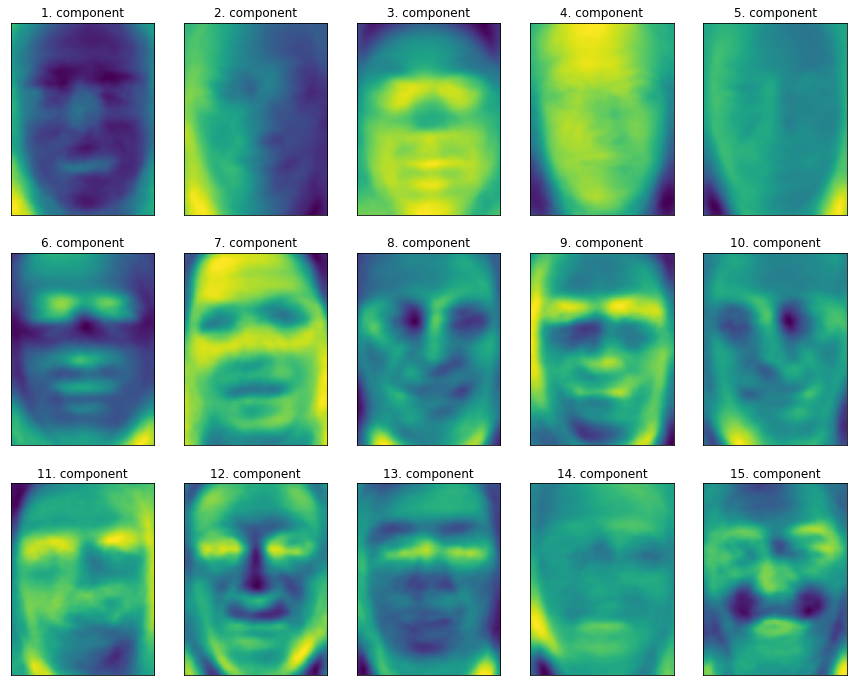

In [52]:
fix, axes = plt.subplots(3, 5, figsize=(15, 12), subplot_kw={'xticks': (), 'yticks': ()})

for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape), cmap='viridis')
    ax.set_title("{}. component".format((i + 1)))

### Plot the original image and its representation with N = {10,50,100,500} components

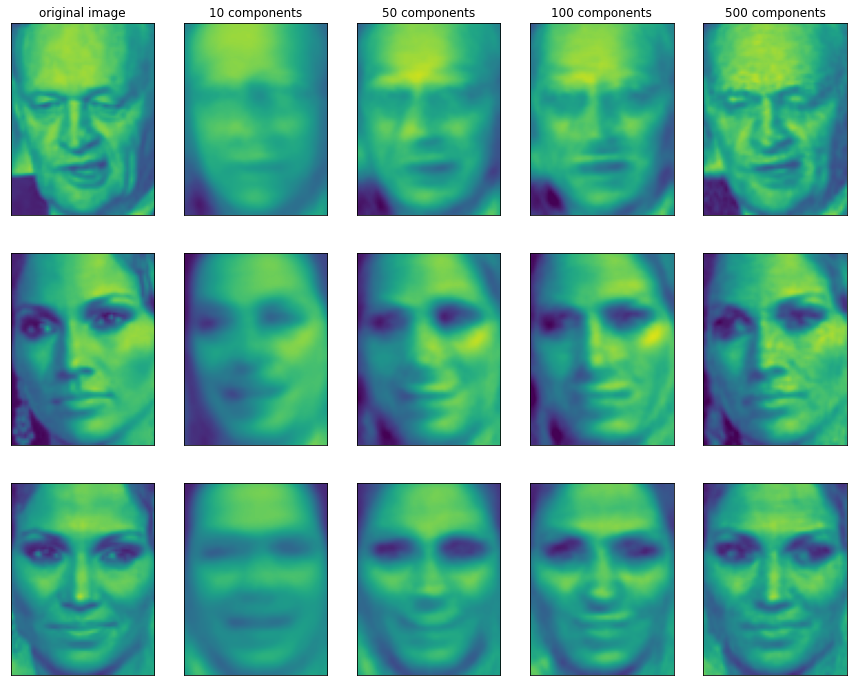

In [53]:
mglearn.plots.plot_pca_faces(X_train, X_test, image_shape);

It's very interesting how 1 component has basic caracteristics of the original picture (orientation, basic parts of a face, etc).

Notice, how adding more components makes the image closer to the original.

### Plotting all images in a 2d-dimension

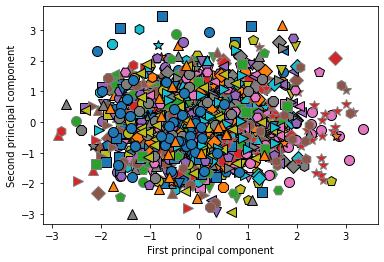

In [56]:
mglearn.discrete_scatter(X_train_pca[:, 0], X_train_pca[:, 1], y_train)

plt.xlabel("First principal component")
plt.ylabel("Second principal component");

Notice how 2 components are not enough to discriminate the classes.